In [81]:
import torch 
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
import torch.nn.functional as F
import sys
import os
cwd = os.getcwd()
sys.path.insert(1, cwd+'/BA_Optimization_ML/MaschineLearning/visualisation')
sys.path.insert(1, cwd+ '/BA_Optimization_ML/MaschineLearning/deeplearningModel')
import LogDataImport
import random
import dataprocessing

from tqdm import tqdm
import time

    
if torch.cuda.is_available() and True:
    device = torch.device("cuda:0")  # you can continue going on here, like cuda:1 cuda:2....etc. 
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")    
    
torch.manual_seed(0)

Running on the CPU


In [6]:
with tqdm(total=4) as pbar:
    #Json
    #Jsondata=json_ImExport.loadData("/Users/leonkiesgen/Documents/Python/Kappa_variation_vmax100.json")
    #Log File (Monteblanco)
    pbar.update(1)
    

    Logdata_MB=LogDataImport.get_data("/Users/leonkiesgen/Documents/Python/mod_local_trajectory/logs/ltpl/2019_12_01/15_00_59_data.csv")

    #Log File (Berlin)
    pbar.update(1)
    ValLogdata_B=LogDataImport.get_data("/Users/leonkiesgen/Documents/Python/mod_local_trajectory/logs/ltpl/2019_12_05/12_19_36_data.csv")

    #Log File (Modena)
    pbar.update(1)
    ValLogdata_M=LogDataImport.get_data("/Users/leonkiesgen/Documents/Python/mod_local_trajectory/logs/ltpl/2019_12_05/15_41_27_data.csv")

    #Log File (zalazone)
    pbar.update(1)
    ValLogdata_Z=LogDataImport.get_data("/Users/leonkiesgen/Documents/Python/mod_local_trajectory/logs/ltpl/2019_12_05/15_51_25_data.csv")


100%|██████████| 4/4 [00:05<00:00,  1.33s/it]


In [145]:
class CNN(nn.Module):

    def __init__(self):
        super(CNN,self).__init__()

        self.c1=nn.Conv1d(in_channels=1,out_channels=15,kernel_size=27,padding=13)
        self.c2=nn.Conv1d(in_channels=15,out_channels=25,kernel_size=51,padding=25)
        self.c3=nn.Conv1d(in_channels=25,out_channels=1,kernel_size=9,padding=4)
    def forward(self,x):
        x=F.relu(self.c1(x))
        x=F.relu(self.c2(x))
        out=torch.sigmoid(self.c3(x))

        return out

In [146]:
inp=torch.rand(1,1,94)
model=CNN()
p=model(inp)
p.squeeze()

tensor([0.5013, 0.5064, 0.5035, 0.5051, 0.5079, 0.5026, 0.5109, 0.5035, 0.4981,
        0.5008, 0.5102, 0.5064, 0.5072, 0.4991, 0.5016, 0.5035, 0.5051, 0.5032,
        0.5134, 0.5046, 0.5070, 0.5024, 0.5137, 0.4988, 0.5114, 0.4961, 0.5001,
        0.5073, 0.5098, 0.5089, 0.5048, 0.4996, 0.4978, 0.5168, 0.4988, 0.5035,
        0.5119, 0.5036, 0.5084, 0.5203, 0.4999, 0.5105, 0.5123, 0.5116, 0.5101,
        0.5162, 0.4952, 0.5085, 0.5026, 0.5106, 0.5032, 0.5135, 0.5016, 0.5115,
        0.5009, 0.5099, 0.5079, 0.5053, 0.5050, 0.4990, 0.5064, 0.5098, 0.5071,
        0.4965, 0.5174, 0.5086, 0.5065, 0.5063, 0.5049, 0.5014, 0.5162, 0.4993,
        0.5007, 0.5034, 0.5121, 0.5036, 0.5084, 0.5077, 0.5154, 0.5111, 0.5085,
        0.4968, 0.5017, 0.5011, 0.5102, 0.5022, 0.5109, 0.5118, 0.5199, 0.5059,
        0.5115, 0.5168, 0.5135, 0.5130], grad_fn=<SqueezeBackward0>)

In [147]:
traindata=dataprocessing.prepareData([ValLogdata_B,ValLogdata_M,ValLogdata_Z],1)

random.shuffle(traindata)
NumSample=len(traindata)
valdata=dataprocessing.prepareData([Logdata_MB])

inputT=traindata[3][0].view(1,1,-1)
print(inputT.shape)

r_out= model(inputT)

print(r_out.squeeze())

70.0
0.001
70.0
0.001
torch.Size([1, 1, 105])
tensor([0.5119, 0.4884, 0.4721, 0.4638, 0.2584, 0.0891, 0.1463, 0.0555, 0.0925,
        0.1733, 0.4601, 0.5884, 0.5581, 0.5275, 0.5667, 0.5786, 0.6583, 0.7071,
        0.7892, 0.6832, 0.8715, 0.8642, 0.9004, 0.9479, 0.8666, 0.8345, 0.8868,
        0.9282, 0.9293, 0.9260, 0.9580, 0.9538, 0.9282, 0.8792, 0.7750, 0.7086,
        0.6430, 0.5441, 0.4087, 0.3454, 0.3491, 0.3598, 0.3965, 0.3969, 0.3715,
        0.3518, 0.3394, 0.3336, 0.3154, 0.3322, 0.3606, 0.3798, 0.3581, 0.3306,
        0.3201, 0.3323, 0.3123, 0.3049, 0.3096, 0.3368, 0.3740, 0.3770, 0.3820,
        0.3766, 0.3722, 0.3683, 0.3714, 0.3776, 0.3863, 0.3965, 0.4094, 0.4189,
        0.4208, 0.4181, 0.4117, 0.4077, 0.4181, 0.4274, 0.4388, 0.4431, 0.4514,
        0.4551, 0.4605, 0.4619, 0.4566, 0.4542, 0.4618, 0.4652, 0.4703, 0.4737,
        0.4766, 0.4780, 0.4803, 0.4814, 0.4814, 0.4770, 0.4808, 0.4825, 0.4885,
        0.4922, 0.4907, 0.5011, 0.5063, 0.4948, 0.4924],
       grad_fn=<S

In [148]:
from IPython.core.debugger import set_trace

from torch import optim
criterion = nn.L1Loss()
optimizer = optim.SGD(model.parameters(), lr=0.01)


num_epochs = 10
train_tracker, val_tracker, accuracy_tracker = [], [], []


for i in range(num_epochs):
    cum_loss = 0
    random.shuffle(traindata)
    
    for batch, (inp, vel) in enumerate(traindata,1):

        inp=inp.view(1,1,-1)
        optimizer.zero_grad()
        output = model(inp)
        output=output.squeeze()
        #print(output.shape)
        vel=vel.squeeze()
        loss = criterion(output, vel)

        loss.backward()
        optimizer.step()

        cum_loss += loss.item()
        if batch%100==0:
            print("-",end="")


    train_tracker.append(cum_loss/len(traindata))
    print(f"Epoch({i+1}/{num_epochs}) | Training loss: {cum_loss/len(traindata)} | " ,end="")
    
    test_loss = 0
    num_correct = 0
    total = 0

    random.shuffle(valdata)
    for batch, (inp, vel) in enumerate(valdata,1):
        inp=inp.view(1,1,-1)
        output = model(inp)
        output=output.squeeze()
        vel=vel.squeeze()
        batch_loss = criterion(output, vel)        
        test_loss += batch_loss.item()
        if batch%100==0:
            print(".",end="")
        
    
    val_tracker.append(test_loss/len(valdata))
    print(f"Val loss: {test_loss/len(valdata)} | ")

----------------------------------------------Epoch(1/10) | Training loss: 0.048719525219808914 | ..................Val loss: 0.05774172319255106 | 
----------------------------------------------Epoch(2/10) | Training loss: 0.032561562864834234 | ..................Val loss: 0.0516863295150505 | 
----------------------------------------------Epoch(3/10) | Training loss: 0.02841893871171543 | ..................Val loss: 0.049567231319479536 | 
----------------------------------------------Epoch(4/10) | Training loss: 0.026994012356198464 | ..................Val loss: 0.04635533347049084 | 
----------------------------------------------Epoch(5/10) | Training loss: 0.02614163348528867 | ..................Val loss: 0.04469540716507648 | 
----------------------------------------------Epoch(6/10) | Training loss: 0.025128159115715826 | ..................Val loss: 0.0481080140255602 | 
----------------------------------------------Epoch(7/10) | Training loss: 0.02465275757912244 | ............

In [150]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import time


def visual(x):
    #The Visualisation
    NR=x
    #Loss Functions
    criterion = nn.L1Loss()
    #criterion = nn.MSELoss()

    # Data
    testdata_inp,testdata_inp_V,testdata_lable,testdata_lable_V=[],[],[],[]
    testdata_inp=torch.clone(traindata[NR][0])
    testdata_inp_V=torch.clone(valdata[NR][0])
    testdata_lable=torch.clone(traindata[NR][1])
    testdata_lable_V=torch.clone(valdata[NR][1])
    

    
    with torch.no_grad():
        t1=time.time()
        testdata_inp=testdata_inp.view(1,1,-1)
        pred=model(testdata_inp)
        pred=pred.squeeze()
        t2=time.time()
        print("Evolived Time: " , (t2-t1)*1000,"ms")

    %matplotlib inline
    pred=70*(np.array(pred))
    real=70*(np.array(testdata_lable.tolist()))
    plt.plot(pred,label="Pred")
    plt.plot(real,label= "Real_Optimizer")
    plt.legend(["ML_Pred","Opt_Real"])
    #plt.title("| "+name + " | Loss: "+str(np.round(loss.item(),4))+""+ " | " )
    plt.xlabel("Steps")
    plt.ylabel("Velocity")
    
    
    LossEval=False
    if LossEval:
        R2Score_T=Scoring(traindata,"R2")
        print("R2_T: " ,R2Score_T)
        R2Score_V=Scoring(valdata,"R2")
        print("R2_V: " ,R2Score_V)
        
        MAEScore_T=Scoring(traindata,"MAE")
        print("MAE_T: " ,MAEScore_T)
        MAEScore_V=Scoring(valdata,"MAE")
        print("MAE_V: " ,MAEScore_V)
        
        MSEScore_T=Scoring(traindata,"MSE")
        print("MSE_T: " ,MSEScore_T)
        MSEScore_V=Scoring(valdata,"MSE")
        print("MSE_V: " ,MSEScore_V)
        

Evolived Time:  2.2559165954589844 ms


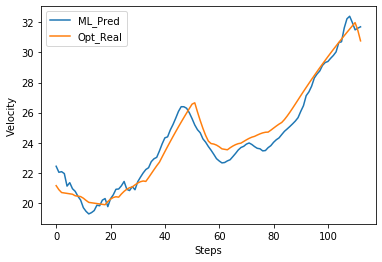

In [161]:
visual(59)

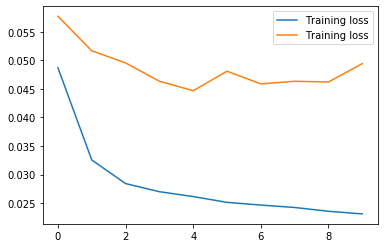

In [149]:
%matplotlib inline
plt.plot(train_tracker, label='Training loss')
plt.plot(val_tracker, label='Training loss')

plt.legend()